# Audio analysis

In [1]:
# %pip install moviepy pydub librosa webrtcvad praat-parselmouth numpy scipy

In [2]:
# %pip install openpyxl

In [1]:
import os
from moviepy import VideoFileClip
from pydub import AudioSegment
import numpy as np
import librosa
import webrtcvad
import parselmouth

In [4]:
import contextlib
import sys

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr
            
def extract_audio(video_path, audio_path="audio.wav"):
    with suppress_output():
        video = VideoFileClip(video_path)
        video.audio.write_audiofile(audio_path, codec='pcm_s16le', logger=None)
    return audio_path

In [5]:
def analyze_with_pydub(audio_path):
    audio = AudioSegment.from_wav(audio_path)
    duration = len(audio) / 1000.0
    loudness = []

    frame_ms = 100
    for i in range(0, len(audio), frame_ms):
        frame = audio[i:i+frame_ms]
        loudness.append(frame.dBFS)

    loudness = np.array(loudness)
    silence_ratio = np.sum(loudness < -35) / len(loudness)

    return {
        #"Pydub: Duration (s)": round(duration, 2),
        "pydub_avg_loudness_dBFS": round(np.mean(loudness), 2),
        "pydub_silence_%": round(silence_ratio * 100, 2),
    }

def analyze_with_librosa(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    rms = librosa.feature.rms(y=y)[0]
    duration = librosa.get_duration(y=y, sr=sr)

    # Pitch
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = pitches[magnitudes > np.median(magnitudes)]
    avg_pitch = np.mean(pitch) if len(pitch) > 0 else 0

    silence_ratio = np.sum(rms < 0.005) / len(rms)

    return {
        #"librosa_duration (s)": round(duration, 2),
        "librosa_avg_RMS": round(np.mean(rms), 4),
        "librosa_silence_%": round(silence_ratio * 100, 2),
        "librosa_avg_pitch_Hz": round(avg_pitch, 2),
    }

def analyze_with_vad(audio_path):
    import wave
    vad = webrtcvad.Vad(2)  # aggressiveness from 0 to 3

    with wave.open(audio_path, 'rb') as wf:
        sample_rate = wf.getframerate()
        frame_duration = 30  # ms
        frame_size = int(sample_rate * frame_duration / 1000)
        voiced_frames = 0
        total_frames = 0

        while True:
            frame = wf.readframes(frame_size)
            if len(frame) < frame_size * 2:
                break
            is_speech = vad.is_speech(frame, sample_rate)
            voiced_frames += int(is_speech)
            total_frames += 1

    speech_ratio = voiced_frames / total_frames if total_frames > 0 else 0
    return {
        "WebRTC_VAD_speech_%": round(speech_ratio * 100, 2),
        "WebRTC_VAD_silence_%": round((1 - speech_ratio) * 100, 2),
    }

def analyze_with_parselmouth(audio_path):
    snd = parselmouth.Sound(audio_path)

    pitch = snd.to_pitch()
    mean_pitch = parselmouth.praat.call(pitch, "Get mean", 0, 0, "Hertz")

    point_process = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", 75, 500)
    jitter = parselmouth.praat.call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    shimmer = parselmouth.praat.call([snd, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

    return {
        "parselmouth_mean_pitch_Hz": round(mean_pitch, 2) if mean_pitch else None,
        "parselmouth_jitter": round(jitter, 4) if jitter else None,
        "parselmouth_shimmer": round(shimmer, 4) if shimmer else None,
    }


In [6]:
from pydub import AudioSegment

def convert_audio_for_vad(input_path, output_path="vad_ready.wav"):
    audio = AudioSegment.from_wav(input_path)
    audio = audio.set_frame_rate(16000).set_channels(1).set_sample_width(2)
    audio.export(output_path, format="wav")
    return output_path


In [7]:
def full_analysis(video_path):
    audio_path = extract_audio(video_path)
    vad_ready_path = convert_audio_for_vad(audio_path)

    results = {}
    results.update(analyze_with_pydub(audio_path))
    results.update(analyze_with_librosa(audio_path))
    results.update(analyze_with_vad(vad_ready_path))
    results.update(analyze_with_parselmouth(audio_path))
    return results

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
data = pd.read_excel("data/fragments/dataset.xlsx")

In [10]:
features = ['pydub_avg_loudness_dBFS', 'pydub_silence_%', 'librosa_avg_RMS', 'librosa_silence_%', 'librosa_avg_pitch_Hz', 'WebRTC_VAD_speech_%', 'WebRTC_VAD_silence_%', 'parselmouth_mean_pitch_Hz', 'parselmouth_jitter', 'parselmouth_shimmer']
data[features] = np.float64(0)

In [ ]:
# videos = "data\\fragments\\videos"
# for video in os.listdir(videos):
#     video_path = os.path.join(videos, video)
#     for segment in os.listdir(video_path):
#         segment_path = os.path.join(video_path, segment)
#         result = full_analysis(segment_path)
#         data.loc[data['segment_name'] == segment[:-4], features] = list(result.values())
# 
# data.to_csv("dataset_audio.csv", index=False)

In [3]:
# data.to_csv("dataset_audio.csv", index=False)
data = pd.read_csv("data/datasets/dataset_audio.csv")

In [7]:
data

,segment_name,confidence_assessment,pydub_avg_loudness_dBFS,pydub_silence_%,librosa_avg_RMS,librosa_silence_%,librosa_avg_pitch_Hz,WebRTC_VAD_speech_%,WebRTC_VAD_silence_%,parselmouth_mean_pitch_Hz,parselmouth_jitter,parselmouth_shimmer
0,8Dv2Hdf5TRg_seg000,4.0,-28.62,28.43,0.0695,17.20,1636.209961,81.43,18.57,221.38,0.0256,0.1125
1,8Dv2Hdf5TRg_seg001,4.0,-27.74,24.44,0.0790,21.63,1552.560059,80.63,19.37,217.52,0.0257,0.1084
2,8Dv2Hdf5TRg_seg002,3.0,-26.05,18.63,0.0830,14.81,1551.660034,86.09,13.91,214.47,0.0254,0.1136
3,8Dv2Hdf5TRg_seg003,3.0,-26.63,23.49,0.0834,17.71,1546.699951,81.70,18.30,217.81,0.0263,0.1092
4,8Dv2Hdf5TRg_seg004,3.0,-25.87,19.54,0.0803,11.90,1533.709961,82.07,17.93,227.92,0.0266,0.1134
...,...,...,...,...,...,...,...,...,...,...,...,...
507,XZBZ5aBEUrs_seg018,4.0,-30.14,30.41,0.0673,22.27,1796.040039,86.83,13.17,222.30,0.0164,0.0844
508,XZBZ5aBEUrs_seg019,4.0,-27.83,23.14,0.0670,12.92,1916.500000,90.38,9.62,233.98,0.0166,0.0858
509,XZBZ5aBEUrs_seg020,3.0,-27.32,24.61,0.0833,17.67,1838.819946,88.25,11.75,225.90,0.0154,0.0864
510,XZBZ5aBEUrs_seg021,3.0,-27.37,24.44,0.0804,16.92,1871.739990,92.47,7.53,222.34,0.0176,0.0860


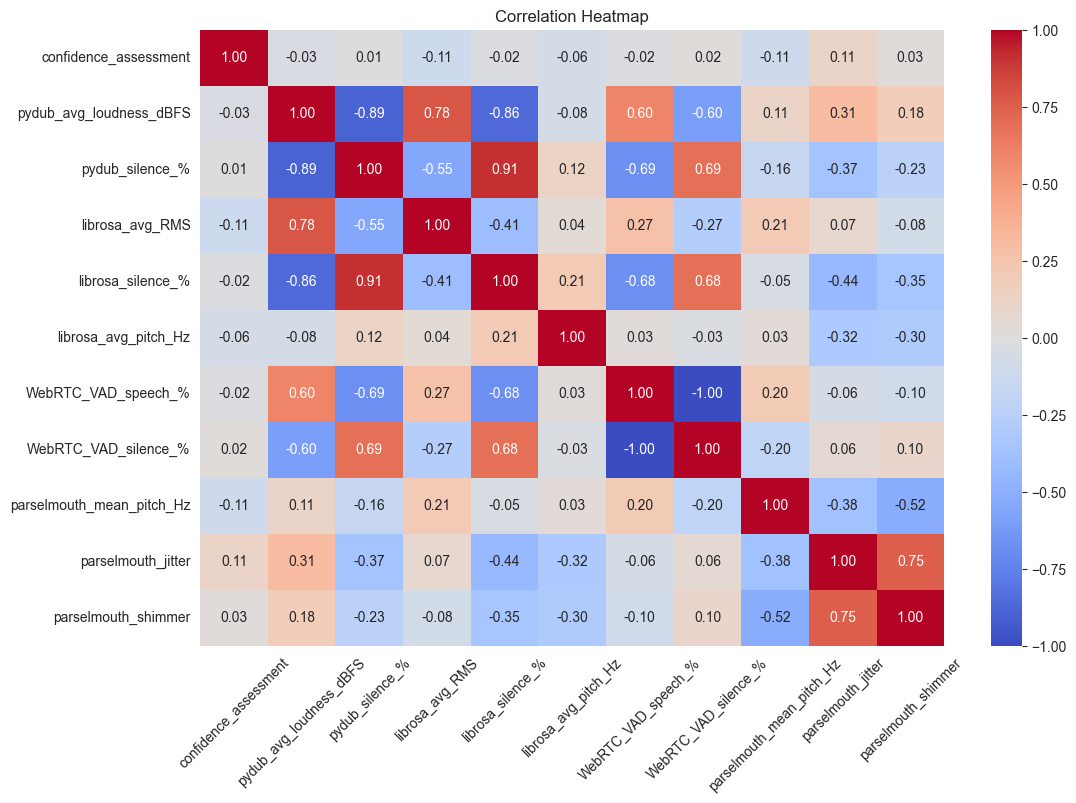

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.drop('segment_name', axis=1).corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)

ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_ha('right')
    label.set_position((label.get_position()[0] - 0.1, label.get_position()[1]))

plt.show()

In [8]:
# %pip install pyAudioAnalysis

     ---------------------------------------- 0.0/41.3 MB ? eta -:--:--
     --------------------------------------- 0.0/41.3 MB 682.7 kB/s eta 0:01:01
     --------------------------------------- 0.0/41.3 MB 495.5 kB/s eta 0:01:24
     --------------------------------------- 0.1/41.3 MB 819.2 kB/s eta 0:00:51
     ---------------------------------------- 0.2/41.3 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.4/41.3 MB 2.0 MB/s eta 0:00:21
      --------------------------------------- 0.7/41.3 MB 2.8 MB/s eta 0:00:15
     - -------------------------------------- 1.4/41.3 MB 4.4 MB/s eta 0:00:10
     -- ------------------------------------- 2.4/41.3 MB 6.9 MB/s eta 0:00:06
     -- ------------------------------------- 3.1/41.3 MB 8.1 MB/s eta 0:00:05
     --- ------------------------------------ 3.5/41.3 MB 7.9 MB/s eta 0:00:05
     --- ------------------------------------ 3.9/41.3 MB 8.6 MB/s eta 0:00:05
     ----- ---------------------------------- 5.3/41.3 M


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# import os
# from pyAudioAnalysis import audioSegmentation as aS
# from pyAudioAnalysis import ShortTermFeatures
# from pyAudioAnalysis import MidTermFeatures
# from pydub import AudioSegment
# import numpy as np
# import matplotlib.pyplot as plt
# import subprocess
# 
# def extract_audio(video_path, out_wav="temp_audio.wav"):
#     audio = AudioSegment.from_file(video_path)
#     audio = audio.set_channels(1).set_frame_rate(16000)
#     audio.export(out_wav, format="wav")
#     return out_wav
# 
# def remove_silence(audio_path):
#     print(">> Removing silence...")
#     segments = aS.silence_removal(audio_path, 16000, 0.05, 0.05, smooth_window=1.0, weight=0.3, plot=True)
#     return segments
# 
# def extract_features(audio_path):
#     print(">> Extracting mid- and short-term features...")
#     [Fs, x] = aS.read_audio_file(audio_path)
#     x = aS.stereo_to_mono(x)
# 
#     # Extract short-term features
#     st_win, st_step = 0.05, 0.025
#     mt_win, mt_step = 2.0, 1.0
# 
#     features, feature_names = MidTermFeatures.mid_feature_extraction(x, Fs, mt_win, mt_step, st_win, st_step)
# 
#     mean_features = np.mean(features, axis=1)
#     feature_summary = dict(zip(feature_names, mean_features))
# 
#     return feature_summary
# 
# def plot_some_features(features, selected=["energy", "zero crossing rate", "spectral centroid"]):
#     for feat_name in selected:
#         keys = [k for k in features if feat_name in k.lower()]
#         for key in keys:
#             print(f"{key}: {features[key]:.4f}")
# 
# def run_pipeline(video_path):
#     audio_path = extract_audio(video_path)
#     _ = remove_silence(audio_path)
#     features = extract_features(audio_path)
#     plot_some_features(features)
#     return features


In [10]:
# result = run_pipeline("data\\fragments\\videos\\8Dv2Hdf5TRg\\8Dv2Hdf5TRg_seg000.mp4")

>> Removing silence...


AttributeError: 'str' object has no attribute 'ndim'